- Download Model Weights from https://www.kaggle.com/hypocrites/imageaiweighs
- (Kernel Notebook > File > Add or Upload Data > Datasets > Search By URL > {Above URL})

In [15]:
"""
!pip install imageai --quiet
!pip install tensorflow==1.14.0 --quiet
!pip install tensorflow-gpu==1.14.0 --quiet
"""
pass

In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from IPython.display import clear_output
from sklearn import preprocessing

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# example of converting an image with the Keras API
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [17]:
%run paths.py # Load all our paths
%run methods.py # Load all our methods

os.listdir(DATASET_DIR)

['test_images',
 'train_masks.zip',
 'train_images.zip',
 'car_models',
 '.ipynb_checkpoints',
 'car_models_json.zip',
 'car_models.zip',
 'test_masks',
 'train.csv',
 'train_images',
 'test_images.zip',
 'train_masks',
 'camera.zip',
 'sample_submission.csv',
 'car_models_json',
 'test_masks.zip',
 'camera']

In [18]:
df_train = pd.read_csv(os.path.join(DATASET_DIR, 'train.csv'))

# Append a col specifying # of cars, inspired by seshadrikolluri/vehicle-angle-prediction-understanding-eda
df_train['NumCars'] = [int((x.count(' ')+1)/7) for x in df_train['PredictionString']]

# df_train.head()

In [22]:
# show_image(imageId=df_train["ImageId"][0],width=12,addMask=True,markCars=df_train["PredictionString"][0])

2529
TP 5 FP 1 FN 10


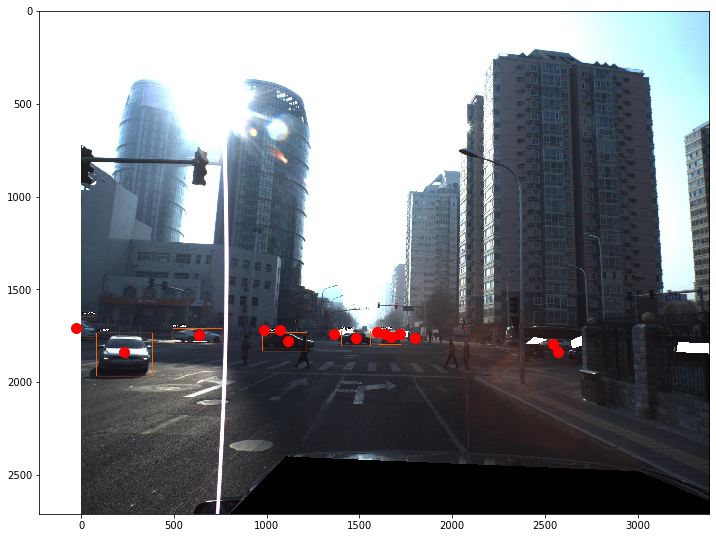

In [21]:
detector = detector_imageai('yolo')

keys = np.array(df_train["ImageId"].keys())
np.random.shuffle(keys)

for key in keys:
    
    #key = 3271 # Just to reproduce the result of a random key taken from print below
    print(key)
    
    image = return_img(imageId=df_train["ImageId"][key])
    
    returned_image, detections = predict_using_detector(detector,image)
    ground_truth = df_train["PredictionString"][key]
                
    TP,FP,FN,TP_points = find_sensitivity(ground_truth,detections)
    print("TP",TP,"FP",FP,"FN",FN)
    
    show_image(img=returned_image,width=12,markCars=ground_truth)
    
    break

In [ ]:
def analyse_detector_stage(detector,name,detection_probability=50):
    
    accuracy = -1
    
    df = df_train.copy()
    
    df["DetectedCars"] = ""
    df["TP"] = ""
    df["FP"] = ""
    df["FN"] = ""
    
    anamoly = ""
    
    detectionsDict = dict()
    
    filename = os.path.join(DATASET_DIR , "detections/"+name+"-detections.csv")
    
    # Open once in w+ mode to clear it
    f = open(filename, "w+")
    f.close()
    newCSV = True

    for instance,imageId in enumerate(df["ImageId"]):
        
        # Keep it open in append mode
        f = open(filename, 'a')
    
        image = return_img(imageId=imageId)

        returned_results = detector.detectCustomObjectsFromImage(
            custom_objects=detector.CustomObjects(car=True),
            input_image=image, 
            input_type="array",
            output_image_path=os.path.join(DATASET_DIR , "detections/"+name+"/"+imageId+".jpg"),
            minimum_percentage_probability=detection_probability,
            extract_detected_objects=True)
        
        detections, objects_path = returned_results
        #returned_image, detections = returned_results
        ground_truth = df_train["PredictionString"][instance]
        
        TP,FP,FN,TP_points = find_sensitivity(ground_truth,detections)
        
        for eachObject, eachObjectPath in zip(detections, objects_path):
            
            for TP_point in TP_points:
                
                if TP_point["box"] == eachObject["box_points"]:
            
                    eachObjectPath = imageId+"-"+str(eachObjectPath.split("objects/")[1].split(".")[0].split("-")[1])
                    detectionsDict[eachObjectPath] = dict()
                    detectionsDict[eachObjectPath]["Probability"] = eachObject["percentage_probability"]
                    # Idea: Replace the following x,y,z by the inverse of get_image_coords fn for mean x,y from detected bounding boxes
                    # or Better: Feed bounding box coordinates to future neural network along with image
                    detectionsDict[eachObjectPath]["x1"] = TP_point["x1"]
                    detectionsDict[eachObjectPath]["x2"] = TP_point["x2"]
                    detectionsDict[eachObjectPath]["y1"] = TP_point["y1"]
                    detectionsDict[eachObjectPath]["y2"] = TP_point["y2"]
                    
                    original_string = TP_point["original_string"]
                    
                    for param,value in original_string.items():
                        detectionsDict[eachObjectPath][param] = value
                    

        df.loc[instance,"DetectedCars"] = len(detections)
        df.loc[instance,"TP"] = TP
        df.loc[instance,"FP"] = FP
        df.loc[instance,"FN"] = FN
        
        cars_actual = df["NumCars"][instance]
        cars_predicted = len(detections)       
        
        if (TP+FP+FN) > 0: # Don't Check accuracy when there are no cars
            accuracy_temp = TP / (TP+FP+FN)
            if accuracy == -1: # No earlier acc set
                accuracy = accuracy_temp
            accuracy = ( accuracy_temp + accuracy ) / 2
        elif cars_actual > 0: # This shouldn't occur when cars in actual are more than 0
            anamoly += f"Anamoly detected for ImageID: {imageId}, (TP+FP+FN)=0 when Actual Cars are {cars_actual}\n"
        
        clear_output(wait=True)
        if(anamoly != ""):
            print(anamoly)
        print(f"{instance+1} Results Predicted. Accuracy so far: {round(accuracy*100,2)}%")
        #display(df)
        
        df_det = pd.DataFrame(detectionsDict)
        df_det = df_det.T
        if(newCSV):
            newCSV = False
            header = True
        else:
            header = False
        df_det.to_csv(f, header=header,index_label='ImageId')
        f.close()
        
    #df_det = pd.DataFrame(detectionsDict)
    #display(df_det.T)
    
    
    return df, detectionsDict

In [ ]:
"""df_yolo, detectionsDict = analyse_detector_stage(detector_yolo,name="yolo")
df_yolo"""
pass

In [ ]:
"""df_ret, detectionsDict = analyse_detector_stage(detector_ret,name="ret")
df_ret"""
pass